In [1]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
SEED = 68857869
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Dataset Download and Preparation

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip
!mkdir images
!find /content/tiny-imagenet-200 -type f -name '*.JPEG' -exec mv {} /content/images \;
!ls images | wc -l

### Data Loading and Preprocessing

In [ ]:
train_cover = keras.utils.image_dataset_from_directory(
    "images",
    image_size=(64,64),
    labels=None,
    validation_split=0.2,
    subset='training',
    seed=SEED
)

train_payload = keras.utils.image_dataset_from_directory(
    "images",
    image_size=(64,64),
    labels=None,
    validation_split=0.2,
    subset='training',
    seed=SEED+100
)

val_cover = keras.utils.image_dataset_from_directory(
    "images",
    image_size=(64,64),
    labels=None,
    validation_split=0.2,
    subset='validation',
    seed=SEED
)

val_payload = keras.utils.image_dataset_from_directory(
    "images",
    image_size=(64,64),
    labels=None,
    validation_split=0.2,
    subset='validation',
    seed=SEED+100
)

train_dataset = tf.data.Dataset.zip(train_cover, train_payload)
val_dataset   = tf.data.Dataset.zip(val_cover, val_payload)

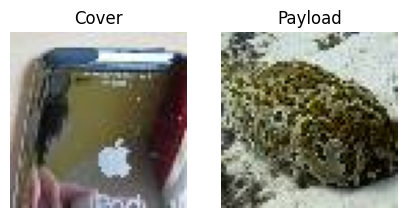

In [41]:
for data in train_dataset.take(1):
    cover = data[0][0].numpy().astype("uint8")
    payload = data[1][0].numpy().astype("uint8")

    fig, ax = plt.subplots(1, 2, figsize=(5, 3))

    ax[0].imshow(cover)
    ax[0].set_title('Cover')
    ax[0].axis('off')

    ax[1].imshow(payload)
    ax[1].set_title('Payload')
    ax[1].axis('off')

    plt.show()

### Model Definition

In [6]:
def conv_layer(x, num_filters, activation='relu', name='conv_layer'):
    x = keras.layers.Conv2D(num_filters, (3, 3), padding='same', name=f'{name}_conv')(x)
    x = keras.layers.BatchNormalization(name=f'{name}_bn')(x)
    x = keras.layers.Activation(activation, name=f'{name}_act')(x)
    return x

def encoder():
    cover_input = keras.Input(shape=(64, 64, 3), name='cover_input')
    payload_input = keras.Input(shape=(64, 64, 3), name='payload_input')

    conc_layer = keras.layers.Concatenate(name='concat_cover_payload')([cover_input, payload_input])

    l1 = conv_layer(conc_layer, 64, name='l1')
    l2 = conv_layer(l1, 128, name='l2')
    l3 = conv_layer(l2, 256, name='l3')
    l4 = conv_layer(l3, 512, name='l4')
    l5 = conv_layer(l4, 512, name='l5')

    x = keras.layers.concatenate([l3, l5], name='concat_l3_l5')
    l6 = conv_layer(x, 256, name='l6')

    x = keras.layers.concatenate([l2, l6], name='concat_l2_l6')
    l7 = conv_layer(x, 128, name='l7')

    x = keras.layers.concatenate([l1, l7], name='concat_l1_l7')
    l8 = conv_layer(x, 64, name='l8')

    steg_image = conv_layer(l8, 3, activation='sigmoid', name='output')

    encoder = keras.Model(inputs=[cover_input, payload_input], outputs=steg_image, name='encoder')
    return encoder